<a href="https://colab.research.google.com/github/mbabazielroy/SA_nCC/blob/main/SA_nCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd /content/drive/MyDrive/Polarity_Dataset

/content/drive/MyDrive/Polarity_Dataset


In [2]:
#from collections import counter
import nltk
nltk.download('stopwords')
from os import listdir
from collections import Counter
from nltk.corpus import stopwords
import string
import re
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Flatten,Embedding
from keras.layers import MaxPooling1D , Conv1D
from keras.utils import plot_model
from keras.utils import pad_sequences
from keras.layers import Input, Dropout, Concatenate

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
#load doc into memory
def load_doc(filename):
  #open the file as read only
  file  = open(filename,'r')
  #read all the text
  text = file.read()
  #close the file
  file.close()
  return text

#load the vocab file
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())

In [4]:
#cleaning the text document(text data)
#remove puncuations, stopwords('English'), Filter out shock tokens
def clean_doc(doc):
  #split the doc into tokens by white space
  tokens = doc.split()
  #prepare regex for char filtering
  re_punc = re.compile('[%s]'%re.escape(string.punctuation))
  #remove puncuation for each word
  tokens = [re_punc.sub('',w)for w in tokens]
  #remove remaining tokens that are not aplhabetic
  tokens = [word for word in tokens if word.isalpha]
  #filter out the stop words
  stop_words = set(stopwords.words('english'))
  tokens = [w for w in tokens if not w in stop_words]
  #filter out any tokens that are small in size
  tokens = [word for word in tokens if len(word)>1]
  return tokens

#load doc , clean,return the lines of the tokens
def doc_to_line(filename, vocab):
  #load doc
  doc = load_doc(filename)
  #clean the document
  tokens = clean_doc(doc)
  #filter by vocab
  tokens  = [w for w in tokens if w in vocab]
  return ' '.join(tokens)

#load all the docs in the directoty
def process_docs(directory,vocab,is_train):
  #define an empty list
  lines = list()
  #iterate over each file in the folder
  for filename in listdir(directory):
    #skip reviews in text set
    if(is_train and filename.startswith('cv9')):
      continue
    #create the full path of the file to open
    path = directory + '/' + filename
    line = doc_to_line(path,vocab)
    #add the doc tothe vocab
    #add_doc_to_vocab(path,vocab)
    #ad to the list
    lines.append(line)
  return lines

#load and clean the data set
def load_clean_dataset(vocab,is_train):
  #load documents
  neg = process_docs('txt_sentoken/neg',vocab, is_train)
  pos = process_docs('txt_sentoken/pos',vocab, is_train)
  docs = pos + neg
  #prepare labels
  labels = np.array([ 0 for _ in range(len(neg))] + [1 for _ in range(len(pos))])
  return docs,labels

In [5]:
#load all the review(training and testing)
train_docs, ytrain = load_clean_dataset(vocab,True)
test_docs, ytest = load_clean_dataset(vocab,False)

In [6]:
#fit a tokenizer
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

#create the tokenizer
tokenizer = create_tokenizer(train_docs)
#define the vocab size
vocab_size = len(tokenizer.word_index)+1
print('Vocab size',vocab_size)
#calculate the max length of the sequence
max_length = max([len(s.split()) for s in train_docs])
print('max_lenght', max_length)

#integre encoding and pad documents
def encode_docs(tokenizer,max_length,docs):
  #integer encode
  encoded = tokenizer.texts_to_sequences(docs)
  #pad sequences
  padded = pad_sequences(encoded, maxlen = max_length, padding = 'post')
  return padded

#encode data
Xtrain = encode_docs(tokenizer,max_length,train_docs)
Xtest = encode_docs(tokenizer,max_length,test_docs)

Vocab size 14062
max_lenght 1241


In [7]:
# Define the multi-channel CNN model
def define_model(vocab_size, max_length):
    # Channel 1
    inputs1 = Input(shape=(max_length,))
    embedding1 = Embedding(vocab_size, 100)(inputs1)
    conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)

    # Channel 2
    inputs2 = Input(shape=(max_length,))
    embedding2 = Embedding(vocab_size, 100)(inputs2)
    conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)

    # Channel 3
    inputs3 = Input(shape=(max_length,))
    embedding3 = Embedding(vocab_size, 100)(inputs3)
    conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)

    # Merge all channels
    merged = Concatenate()([flat1, flat2, flat3])

    # Output layer
    dense1 = Dense(10, activation='relu')(merged)
    output = Dense(1, activation='sigmoid')(dense1)

    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=output)

    # Compile, summarize and plot the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

# Create and compile the model
model = define_model(vocab_size, max_length)

# Encode data for multi-channel input
Xtrain_multi = [Xtrain, Xtrain, Xtrain]
Xtest_multi = [Xtest, Xtest, Xtest]

# Evaluate the model
loss, acc = model.evaluate(Xtrain_multi, ytrain, verbose=0)
print('Training Accuracy: %f' % (acc * 100))

loss, acc = model.evaluate(Xtest_multi, ytest, verbose=0)
print('Testing Accuracy: %f' % (acc * 100))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1241)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1241)]               0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 1241)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1241, 100)            1406200   ['input_1[0][0]']             
                                                                                              

In [8]:
from keras import callbacks
# Implement early stopping to handle overfitting or underfitting
early_stopping = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, restore_best_weights=True)

# Fit the model with early stopping
history = model.fit(Xtrain_multi, ytrain, epochs=10, verbose=2, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/10
45/45 - 26s - loss: 0.6786 - accuracy: 0.6118 - val_loss: 0.9458 - val_accuracy: 0.0000e+00 - 26s/epoch - 569ms/step
Epoch 2/10
45/45 - 27s - loss: 0.5374 - accuracy: 0.6382 - val_loss: 1.1098 - val_accuracy: 0.0028 - 27s/epoch - 608ms/step
Epoch 3/10
45/45 - 25s - loss: 0.3209 - accuracy: 0.9007 - val_loss: 1.1807 - val_accuracy: 0.1778 - 25s/epoch - 549ms/step
Epoch 4/10
45/45 - 22s - loss: 0.2607 - accuracy: 0.9792 - val_loss: 1.3666 - val_accuracy: 0.2194 - 22s/epoch - 491ms/step
Epoch 5/10
45/45 - 25s - loss: 0.2392 - accuracy: 0.9958 - val_loss: 1.0844 - val_accuracy: 0.4444 - 25s/epoch - 566ms/step
Epoch 6/10
45/45 - 23s - loss: 0.2287 - accuracy: 0.9993 - val_loss: 1.1581 - val_accuracy: 0.4528 - 23s/epoch - 504ms/step
Epoch 7/10
45/45 - 27s - loss: 0.2194 - accuracy: 0.9993 - val_loss: 1.3764 - val_accuracy: 0.3417 - 27s/epoch - 601ms/step
Epoch 8/10
45/45 - 23s - loss: 0.2121 - accuracy: 0.9986 - val_loss: 1.1986 - val_accuracy: 0.4611 - 23s/epoch - 502ms/step
Epoc

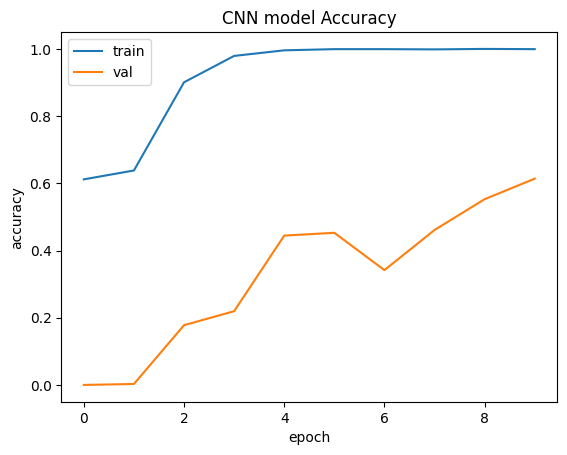

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.savefig('accuracy_plot.png')
plt.show()

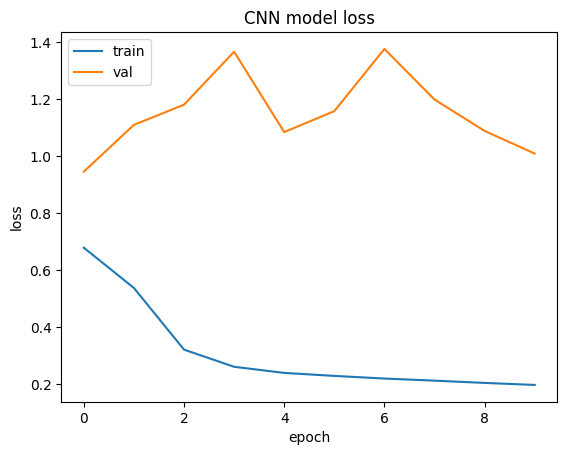

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.savefig('loss_plot.png')
plt.show()

In [11]:
# Modify the predict_sentiment function to handle multi-channel input
def predict_sentiment(review, vocab, tokenizer, model):
    tokens = clean_doc(review)
    tokens = [w for w in tokens if w in vocab]
    line = ' '.join(tokens)
    encoded = encode_docs(tokenizer, max_length, [line])
    encoded_multi = [encoded, encoded, encoded]
    yhat = model.predict(encoded_multi, verbose=0)
    percent_pos = yhat[0, 0]
    if (round(percent_pos) == 0):
        return (1 - percent_pos), 'NEGATIVE'
    return percent_pos, 'POSITIVE'

In [12]:
# Test the sentiment prediction function with multi-channel model
reviews = [
    'The Lion King is arguably up for one of the best films of all time.',
    'At this point in animation history, we can expect no less than perfection from Disney, and they deliver.',
    'With its remarkable narrative, memorable characters, stunning animation, and brilliant music, The Lion King remains the very pinnacle of Disneys animated achievements.',
    'Although far from the worst offender in Disneys canon, The Lion King is nevertheless host to many of the less savory qualities common to the studios output.',
    'Soulless chimera of a film [that] comes off as little more than a glorified tech demo from a greedy conglomerate — a well-rendered but creatively bankrupt self-portrait of a movie studio eating its own tail.',
    'It’s the work of a studio that’s gobbled up the rest of the film industry and is still hungry for more. The Lion King feels less like a remake than a snuff film, and a boring one at that.'
]

with open('SAEval.txt', 'w') as f:
    f.write('Model Summary:\n')
    model.summary(print_fn=lambda x: f.write(x + '\n'))  # Write model summary
    f.write('\n\n')

    f.write('Sentiment Predictions:\n')
    for review in reviews:
        percent, sentiment = predict_sentiment(review, vocab, tokenizer, model)
        f.write(f'Review: {review}\nSentiment: {sentiment}\nPercent: {percent * 100:.2f}%\n\n')
        print('Review:', review, 'Sentiment:', sentiment, 'Percent: %f' % (percent * 100))

Review: The Lion King is arguably up for one of the best films of all time. Sentiment: POSITIVE Percent: 59.759730
Review: At this point in animation history, we can expect no less than perfection from Disney, and they deliver. Sentiment: POSITIVE Percent: 57.246816
Review: With its remarkable narrative, memorable characters, stunning animation, and brilliant music, The Lion King remains the very pinnacle of Disneys animated achievements. Sentiment: NEGATIVE Percent: 56.451753
Review: Although far from the worst offender in Disneys canon, The Lion King is nevertheless host to many of the less savory qualities common to the studios output. Sentiment: POSITIVE Percent: 59.759730
Review: Soulless chimera of a film [that] comes off as little more than a glorified tech demo from a greedy conglomerate — a well-rendered but creatively bankrupt self-portrait of a movie studio eating its own tail. Sentiment: POSITIVE Percent: 59.759730
Review: It’s the work of a studio that’s gobbled up the res